## D6. Visualization of the results

#### 0. Load required libraries, site dependant constants and utility functions.

In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import seaborn as sns
import joblib
from sklearn import metrics

# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site




# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

#### 1. Load the dataset:

In [2]:
import pickle

dataset_name = 'dataset_2013_05-2013_10_sampled_50_modis_blanced_ver_1'

with open('{}.pickle'.format(dataset_name), 'rb') as data:
    dataset = pickle.load(data)
    
features_train = dataset[0]
labels_train = dataset[1]
features_test = dataset[2]
labels_test = dataset[3]

#### 1. Load the model:

In [3]:
# uncomment to load the model and replace with your file, usually just correct the date
model_path = './NEW_model_50_balanced_WATER_NONWATER_MODIS_ver_1.0.pkl'
model = joblib.load(model_path)

# predict the test labels
plabels_test = model.predict(features_test)

In [4]:

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

Classification accuracy 88.1%
Classification F1-score 91.7%


In [5]:
actual_water = np.count_nonzero(labels_test)
predicted_water = np.count_nonzero(plabels_test)

print('Water Test data size:',actual_water)

tp = np.count_nonzero(np.logical_and(labels_test.squeeze(), plabels_test.squeeze()))
print('Water True positive:', tp, 'and recall', 100* tp /actual_water, 'and precision:', tp /predicted_water)

Water Test data size: 32
Water True positive: 26 and recall 81.25 and precision: 0.15950920245398773


In [6]:
class_labels = np.unique(labels_test)
print(class_labels)
class_names = ['non-water', 'water']
class_names

[False  True]


['non-water', 'water']

In [7]:
f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------


C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


         * non-water            = 93.5 |  88.3  | 99.4
         * water                = 26.7 |  81.2  | 16.0


#### 2. Visualization of the results

In [8]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = ftrs.reshape(t * w * h, f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(t, w, h )
        plabels = plabels[..., np.newaxis]
        #eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return plabels

In [2]:
eo_patch = io_utils.load_exemplary_eopatch_from_file(file='../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/',  patch_id=6, random_choice=True)

Loaded from ../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/3474_maxcc_0.05_x-7_y-135


In [147]:
eo_patch

EOPatch(
  data: {
    DATASET_CLD_200_dil_6_str2: numpy.ndarray(shape=(10, 333, 333, 11), dtype=float32)
    LANDSAT_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(10, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI: numpy.ndarray(shape=(10, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_GREEN_NIR: numpy.ndarray(shape=(10, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_ICE: numpy.ndarray(shape=(10, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_1: numpy.ndarray(shape=(10, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_2: numpy.ndarray(shape=(10, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(10, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(10, 333, 333, 11), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(10, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(10, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(10, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS_DAY_0: numpy.n

In [148]:
# TASK FOR PREDICTION
predict_patch = PredictPatch(model, (FeatureType.DATA, 'DATASET_CLD_200_dil_6_str2'), 'WATER_MASK_ST_025')

predictions = []
predictions.append(predict_patch.execute(eo_patch))

In [149]:
len(predictions)

1

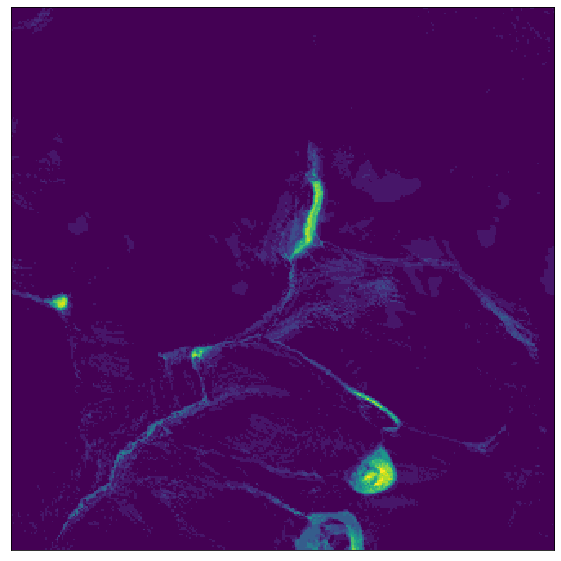

In [3]:
plot_utils.plot_timeless_mask_LANDSAT_8(eo_patch, band_idx=0, mask_acces_name='WATER_MASK_ST_025_COUNT' )

2019-05-08 23:42:28
Ploting...


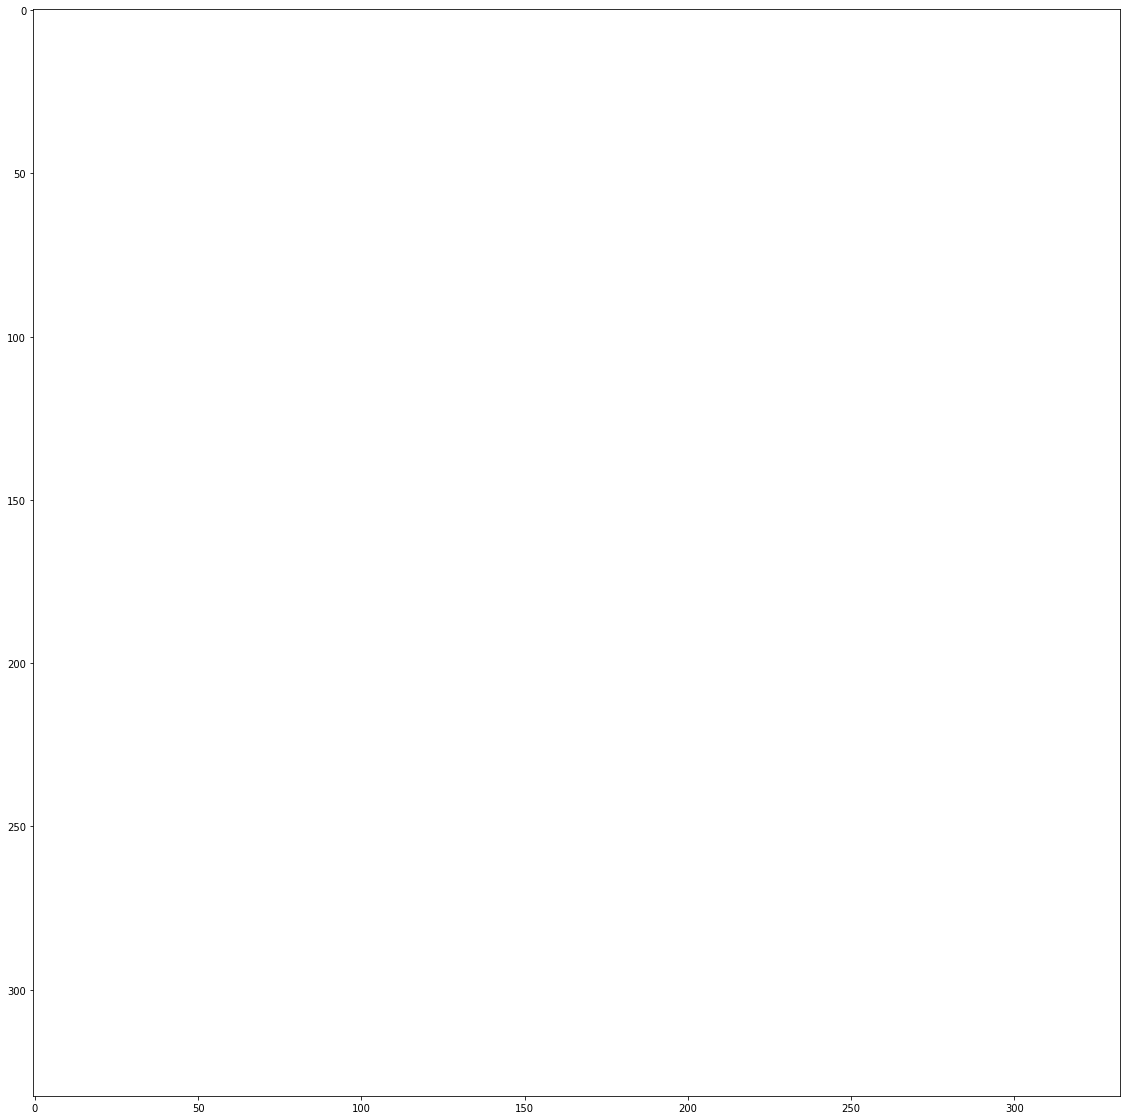

In [15]:
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch, datetime_idx=2 )

2013-08-20 15:32:20
Ploting...


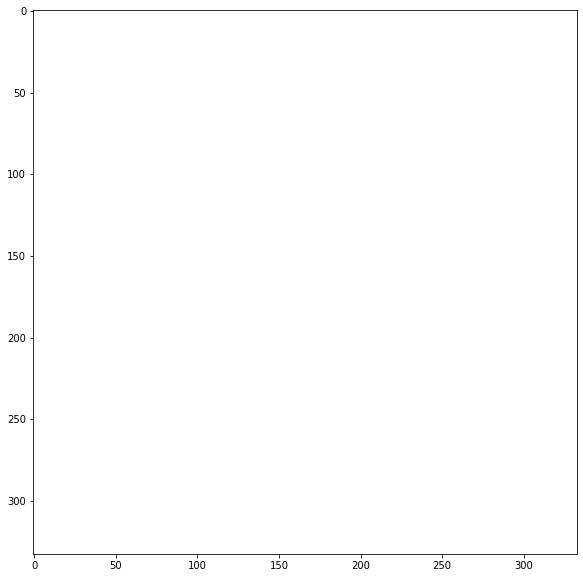

In [163]:
plot_utils.plot_RGB_MODIS_image(eo_patch, data_acces_name='DATASET_CLD_200_dil_6_str2', datetime_idx=2)

In [18]:
patch_no = 15
reference_patch = eo_patch.mask['WATER_MASK_ST_025'][patch_no]
#inspected_patch = predictions[0][patch_no]

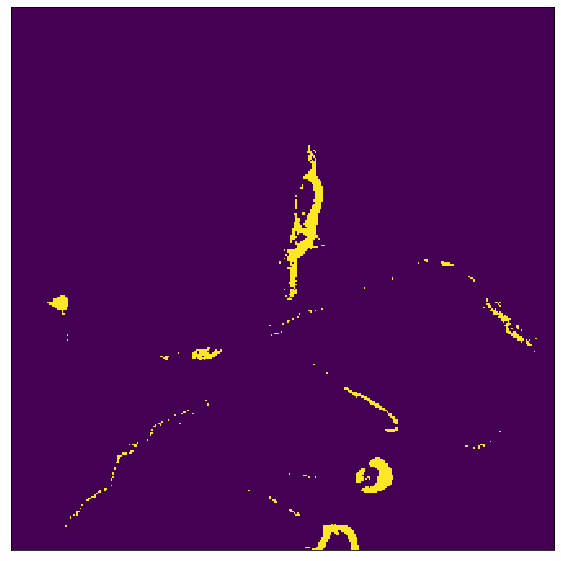

In [19]:
plot_utils.plot_matrix(reference_patch)

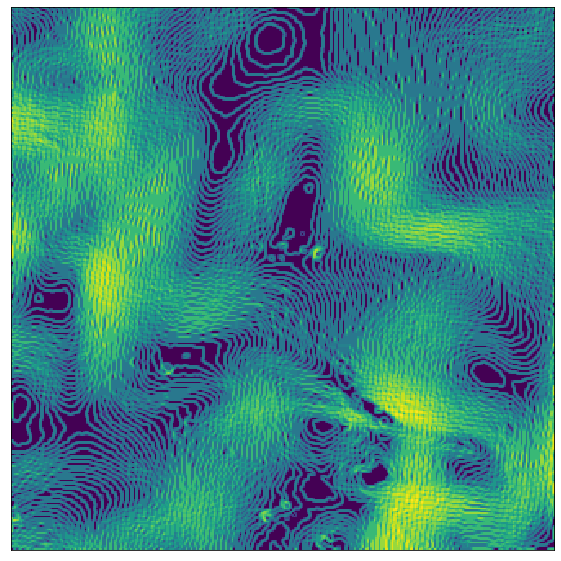

In [12]:
plot_utils.plot_matrix(eo_patch.data_timeless['DEM_SLOPE_LAYER'].squeeze())

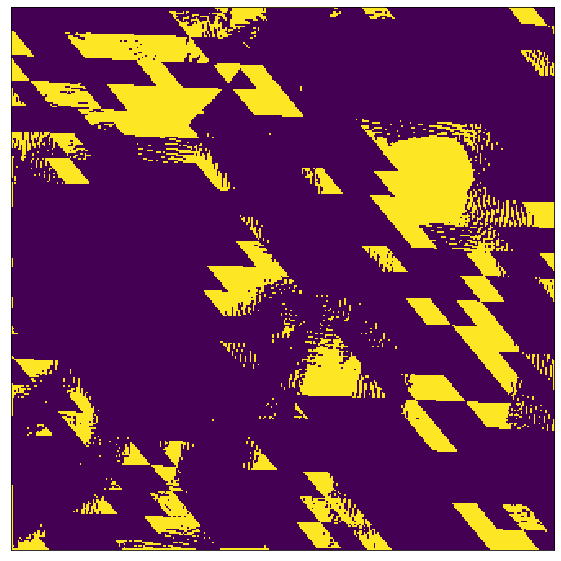

In [172]:
plot_utils.plot_matrix(inspected_patch)

2019-07-17 00:01:03
Band: 0
Band: 1
Band: 2
Band: 3
Band: 4
Band: 5
Band: 6
Band: 7
Band: 8
Band: 9
Band: 10
Saved: 3474_2019_15_DATASET_CLD_200_dil_6_str2.png


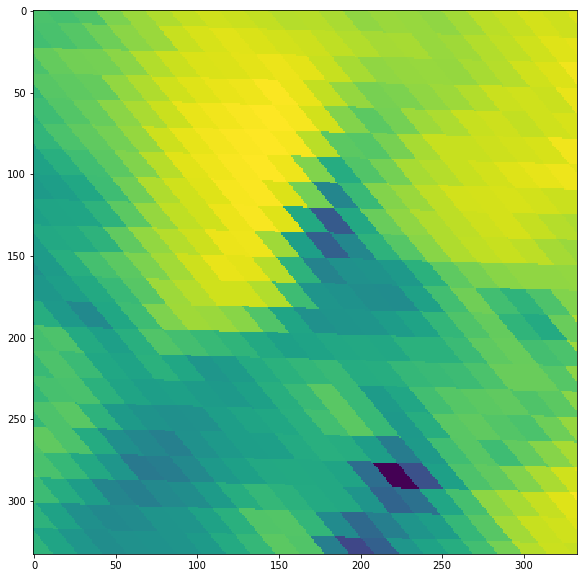

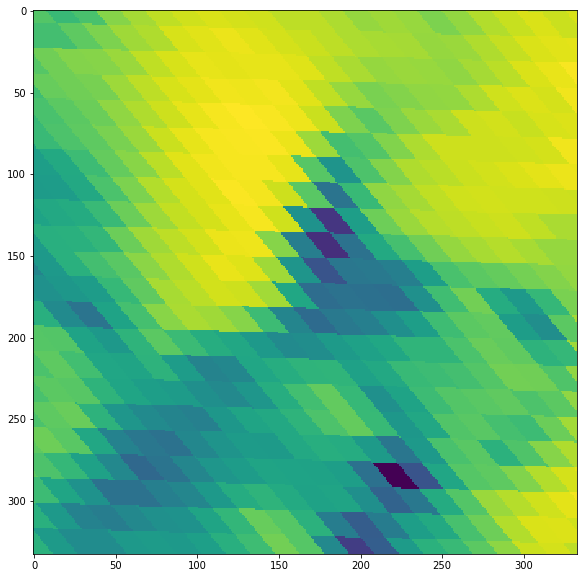

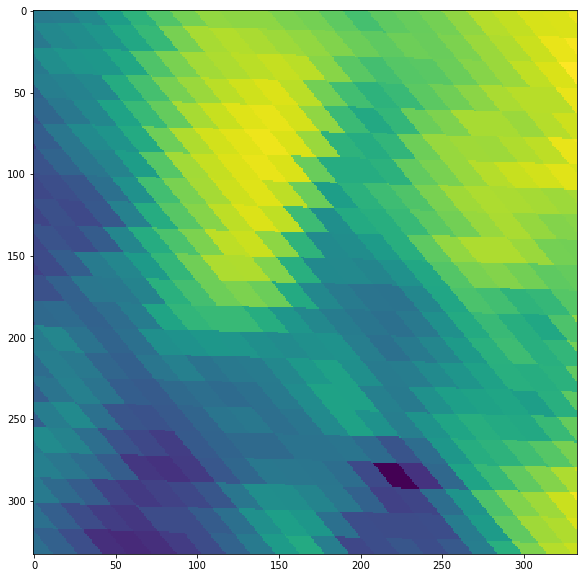

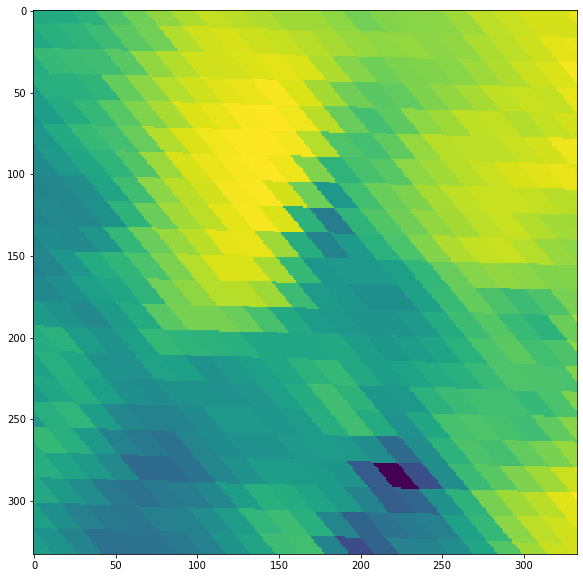

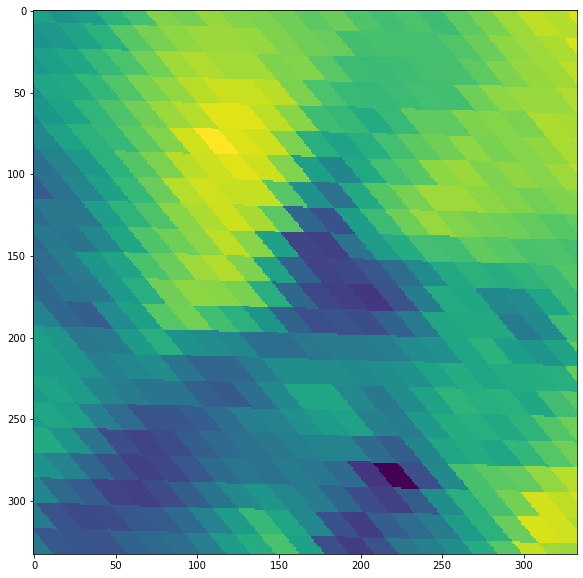

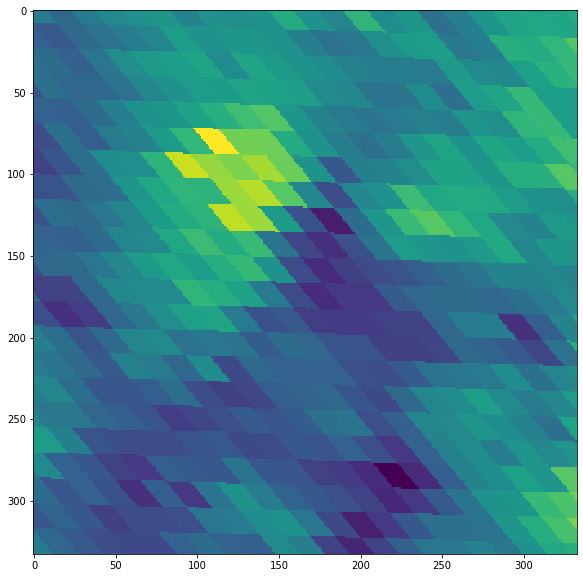

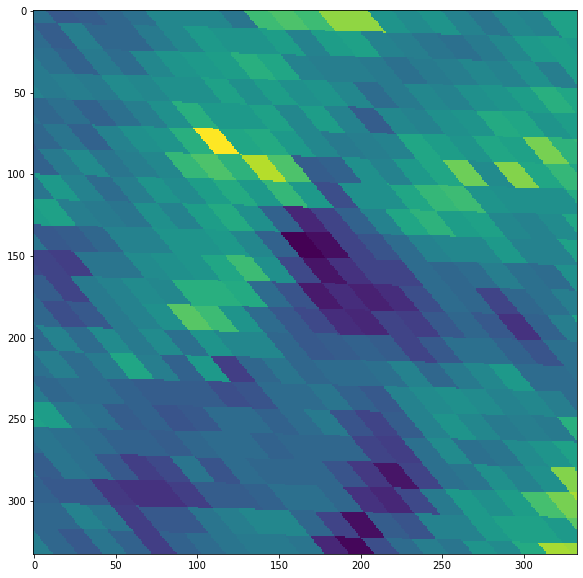

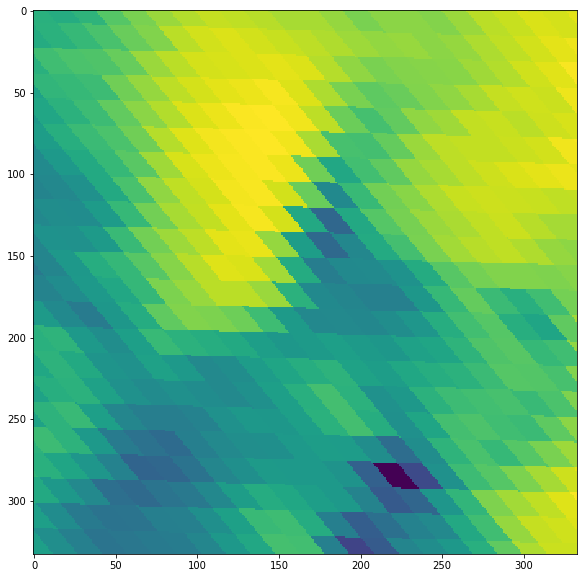

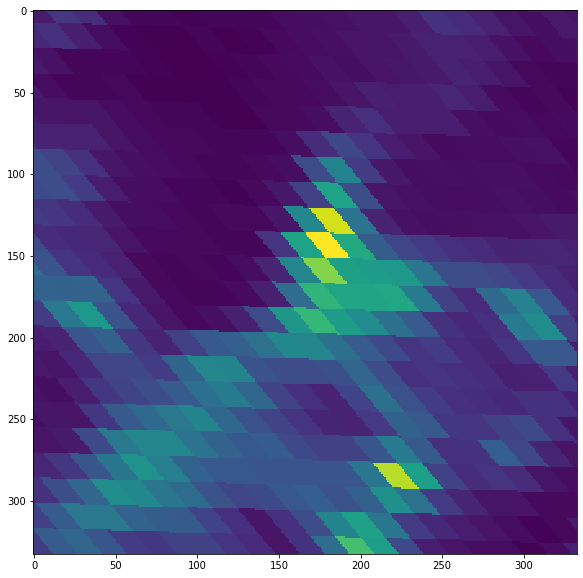

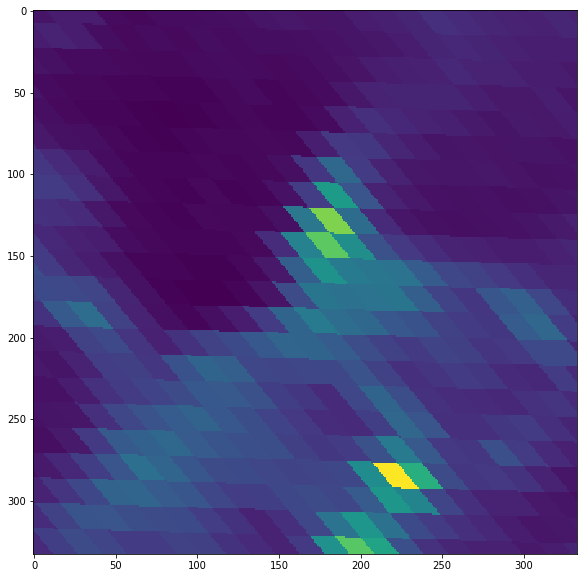

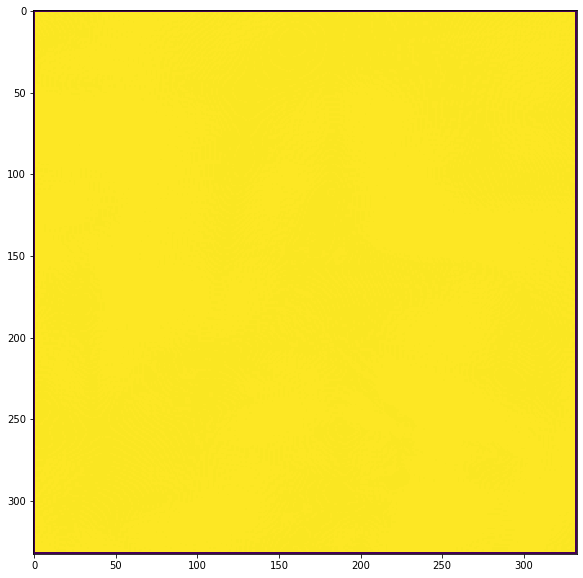

In [20]:
plot_utils.plot_all_bands_in_data_acces_name(eo_patch, data_acces_name='DATASET_CLD_200_dil_6_str2', datetime_idx=15, save=True)

2019-05-08 23:42:28
Ploting...
Saved: 3474_2019_2_DATASET_CLD_200_dil_6_str2.png


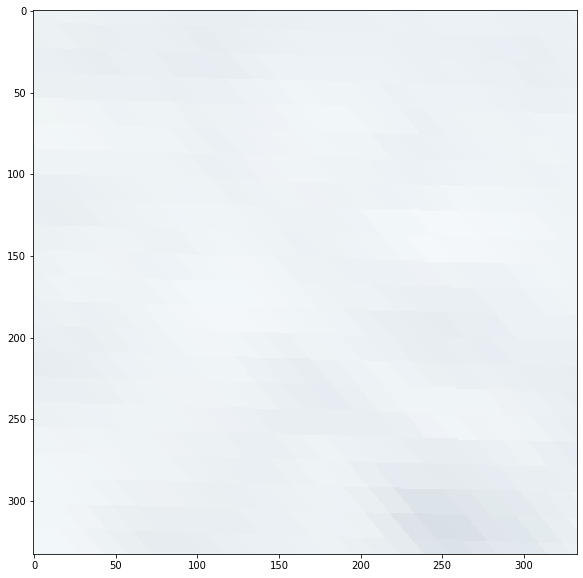

In [14]:
plot_utils.plot_RGB_MODIS_image(eo_patch, data_acces_name='DATASET_CLD_200_dil_6_str2', datetime_idx=2, save=True)